In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
"""
Testing environment with stable_baselines3 library
"""
import sys
sys.path.append('../')

from stable_baselines3.common.env_checker import check_env
from envs.MO_single_agent_battery_storage_env import BatteryStorageInGridEnv

env = BatteryStorageInGridEnv()

check_env(env)

/home/ubuntu/.conda/envs/sustaingym/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


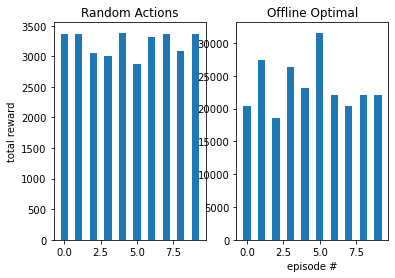

In [3]:
"""
Testing RL agent which randomly chooses actions
"""
import sys
sys.path.append('../')
from typing import List
import numpy as np
import os
import pandas as pd
import gym

from tqdm import tqdm
import matplotlib.pyplot as plt

env = BatteryStorageInGridEnv(date='2020-05', seed=1)

episodes = 10

rewards_lst_1 = []
off_line_rewards_lst_1 = []

for i in tqdm(range(episodes)):
    ob = env.reset()
    done = False
    rewards = np.zeros(env.MAX_STEPS_PER_EPISODE)

    while not done:
        # random action as policy
        action = env.action_space.sample()
        # print("step: ", env.count)
        # print("charging costs: ", env.bats_charge_costs)
        # print("discharging costs: ", env.bats_discharge_costs)
        # print("env load: ", env.load_demand)
        state, reward, done, info = env.step(action)
        rewards[env.count - 1] = reward
    # print("episode {} mean reward: {}".format(i, np.mean(rewards)))
    rewards_lst_1.append(np.sum(rewards))
    ob = env.reset()
    off_line_rewards_lst_1.append(env._calculate_off_optimal_total_episode_reward())

# plot episode # versus total episode reward
plt.subplot(1, 2, 1)
plt.bar(list(range(episodes)), rewards_lst_1, width=0.5)
plt.title("Random Actions")

# naming the y axis 
plt.ylabel('total reward')

# plot episode # versus total offline episode reward
plt.subplot(1, 2, 2)
plt.bar(list(range(episodes)), off_line_rewards_lst_1, width=0.5)
plt.title("Offline Optimal")

# naming the x axis 
plt.xlabel('episode #')

plt.show()

In [4]:
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement

env = BatteryStorageInGridEnv(date='2020-05', seed=1)

stop_train_callback = StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=5, verbose=1)
eval_callback = EvalCallback(env, eval_freq=1000, callback_after_eval=stop_train_callback, verbose=1)

model = PPO("MultiInputPolicy", env, verbose=1)
model.learn(callback=eval_callback)
model.save("ppo_single_agent_battery_env")

del model # remove to demonstrate saving and loading

model = PPO.load("ppo_single_agent_battery_env")

episodes = 10

rewards_lst_4 = []
off_line_rewards_lst_4 = []

for i in tqdm(range(episodes)):
    obs = env.reset()
    done = False
    start = True
    rewards = np.zeros(env.MAX_STEPS_PER_EPISODE)
    avg = np.zeros(1)
    while not done:
        action, _states = model.predict(obs)
        if action.shape[0] == 1:
            action = action.reshape((2,))
        obs, reward, done, info = env.step(action)
        rewards[env.count - 1] = reward
    rewards_lst_4.append(np.sum(rewards))
    ob = env.reset()
    off_line_rewards_lst_4.append(env._calculate_off_optimal_total_episode_reward())

# plot episode # versus total episode reward
plt.bar(list(range(episodes)), rewards_lst_4)

# naming the x axis 
plt.xlabel('episode #') 
# naming the y axis 
plt.ylabel('total reward')

plt.show()

ImportError: cannot import name 'StopTrainingOnNoModelImprovement' from 'stable_baselines3.common.callbacks' (/home/ubuntu/.conda/envs/sustaingym/lib/python3.9/site-packages/stable_baselines3/common/callbacks.py)

In [6]:
from stable_baselines3.ddpg.policies import MultiInputPolicy
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3 import DDPG
import numpy as np

env = BatteryStorageInGridEnv()

# the noise objects for DDPG
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# model = DDPG(MultiInputPolicy, env, action_noise=action_noise, verbose=1)
model = DDPG("MultiInputPolicy", env, action_noise=action_noise, verbose=1)
model.learn(total_timesteps=200000)
model.save("ddpg_single_agent_battery_env")

# del model # remove to demonstrate saving and loading

model = DDPG.load("ddpg_single_agent_battery_env")

episodes = 100

rewards_lst_2 = []

for i in tqdm(range(episodes)):
    obs = env.reset()
    done = False
    start = True
    rewards = np.zeros(env.MAX_STEPS_PER_EPISODE)
    avg = np.zeros(1)
    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)
        rewards[env.count - 1] = reward
    rewards_lst_2.append(np.sum(rewards))

# plot episode # versus total episode reward
plt.bar(list(range(episodes)), rewards_lst_2)

# naming the x axis 
plt.xlabel('episode #') 
# naming the y axis 
plt.ylabel('total reward')

plt.show()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[nan nan]
[nan nan]


/home/ubuntu/.conda/envs/sustaingym/lib/python3.9/site-packages/stable_baselines3/common/policies.py:376: RuntimeWarning: invalid value encountered in multiply
  return low + (0.5 * (scaled_action + 1.0) * (high - low))


ValueError: Parameter value must be nonnegative.